Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting (“curse of dimensionality”) and also reduce computational costs.

Listed below are the 5 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.

1. Compute the d-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors and corresponding eigenvalues for the scatter matrices.
4. Choose k eigenvectors corresponding to top k eigenvalues to form a d×k dimensional matrix WW(where every column represents an eigenvector).
5. Use this d×k eigenvector matrix to transform the samples onto the new subspace.

In [1]:
#import all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#data description Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

Attribute Information:
1.variance of Wavelet Transformed image (continuous)
2.skewness of Wavelet Transformed image (continuous)
3.curtosis of Wavelet Transformed image (continuous)
4.entropy of image (continuous)
5.class (integer) (0-not authentic, 1-authentic)


In [2]:
columns = ["var","skewness","curtosis","entropy","class"]
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/\
data_banknote_authentication.txt",index_col=False, names = columns)

In [3]:
df.head()

,var,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df.describe()

,var,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [5]:
#now have to look at the class distribution
from collections import Counter
Counter(df["class"])

Counter({0: 762, 1: 610})

In [6]:
# split data table into data X and class labels y
X = df.ix[:,0:4].values
y = df.ix[:,4].values

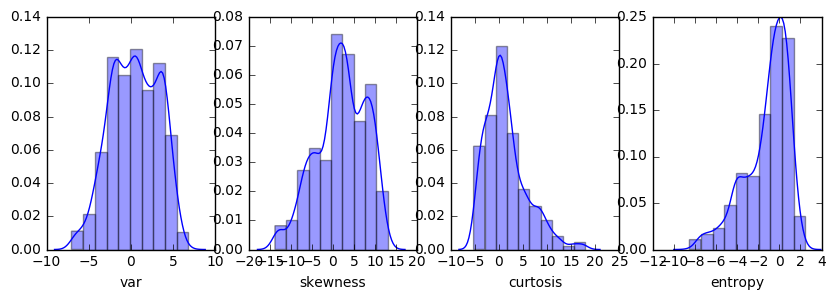

In [7]:
f, ax = plt.subplots(1, 4, figsize=(10,3))
sns.distplot(df["var"],bins=10, ax= ax[0])
sns.distplot(df["skewness"],bins=10, ax=ax[1])
sns.distplot(df["curtosis"],bins=10, ax= ax[2])
sns.distplot(df["entropy"],bins=10, ax=ax[3])
f.savefig('subplot.png')

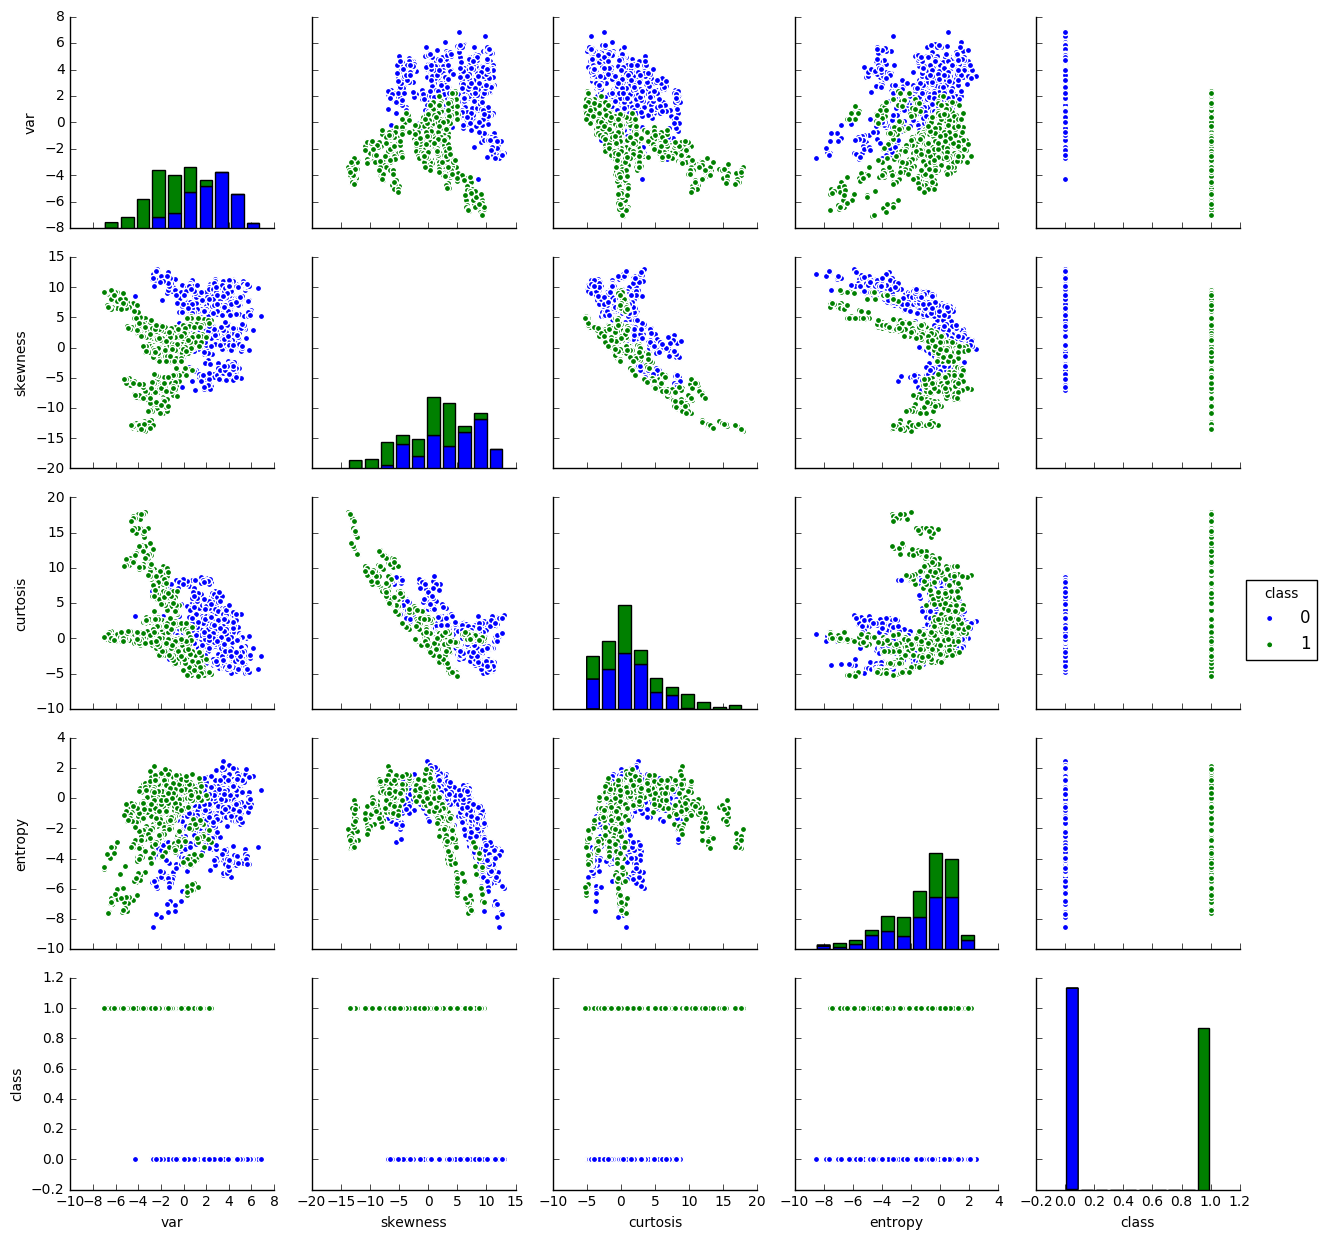

In [8]:
vis1 = sns.pairplot(df, hue="class")
#fig = vis1.get_fig()
vis1.savefig("lda.png")

It should be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated. And even for classification tasks LDA seems can be quite robust to the distribution of the data

In [44]:
np.set_printoptions(precision=5)

In [45]:
mean_vec = []
for i in df["class"].unique():
    mean_vec.append( np.array((df[df["class"]==i].mean()[:4]) ))
print(mean_vec)

[array([ 2.27669,  4.25663,  0.79672, -1.14764]), array([-1.86844, -0.99358,  2.14827, -1.24664])]


In [46]:
SW = np.zeros((4,4))
for i in range(1,4): #2 is number of classes
    per_class_sc_mat = np.zeros((4,4))
    for j in range(df[df["class"]==i].shape[0]):
        row, mv = df.loc[j][:4].reshape(4,1), mean_vec[i].reshape(4,1)
        per_class_sc_mat += (row-mv).dot((row-mv).T)
    SW += per_class_sc_mat

In [47]:
print('within-class Scatter Matrix:\n', SW)

within-class Scatter Matrix:
 [[ 12894.02619  12388.1795   -5025.6094    1110.90897]
 [ 12388.1795   34177.22271 -12505.24345  -4576.31987]
 [ -5025.6094  -12505.24345   7858.82866   1824.14384]
 [  1110.90897  -4576.31987   1824.14384   2876.82305]]


In [48]:
mean_vec[0]

array([ 2.27669,  4.25663,  0.79672, -1.14764])

In [49]:
overall_mean = np.array(df.drop("class", axis=1).mean())
SB = np.zeros((4,4))
for i in range(2): #2 is number of classes
    n = df[df["class"]==i].shape[0]
    mv = mean_vec[i].reshape(4,1)
    overall_mean = overall_mean.reshape(4,1) # make column vector
    SB += n * (mv - overall_mean).dot((mv - overall_mean).T)

print('between-class Scatter Matrix:\n', SB)

between-class Scatter Matrix:
 [[  5.82112e+03   7.37301e+03  -1.89802e+03   1.39029e+02]
 [  7.37301e+03   9.33863e+03  -2.40403e+03   1.76094e+02]
 [ -1.89802e+03  -2.40403e+03   6.18866e+02  -4.53316e+01]
 [  1.39029e+02   1.76094e+02  -4.53316e+01   3.32051e+00]]


In [50]:
e_vals, e_vecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))

print('Eigenvectors \n%s' %e_vecs)
print('\nEigenvalues \n%s' %e_vals)

Eigenvectors 
[[ 0.74375 -0.03293  0.05486 -0.54916]
 [ 0.3459   0.113   -0.15997  0.23491]
 [ 0.57194  0.40441 -0.51472 -0.7511 ]
 [-0.00838  0.90697 -0.84051  0.28124]]

Eigenvalues 
[  5.27056e-01   4.68698e-17   6.53220e-17  -1.05208e-16]


In [51]:
# Make a list of (eigenvalue, eigenvector) tuples
e_pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
e_pairs.sort()
e_pairs.reverse()

print('Eigenvalues in descending order:')
for i in e_pairs:
    print(i[0]) #print eigen values

Eigenvalues in descending order:
0.527056121486
1.05208261374e-16
6.53219919015e-17
4.68698082558e-17


In [52]:
total = sum(e_vals)

In [53]:
var_exp = [(i / total)*100 for i in sorted(e_vals, reverse=True)]

In [54]:
var_exp

[100.0,
 1.2393745037505104e-14,
 8.8927547456783059e-15,
 -1.9961491212271963e-14]

In [55]:
W = np.hstack((e_pairs[0][1].reshape(4,1), e_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.74375 -0.54916]
 [ 0.3459   0.23491]
 [ 0.57194 -0.7511 ]
 [-0.00838  0.28124]]


In [56]:
X_lda = X.dot(W)

In [57]:
X_lda

array([[  4.08927,   2.0298 ],
       [  4.81217,   0.85767],
       [  3.06241,  -4.15815],
       ..., 
       [  2.641  , -15.09731],
       [  1.54877,  -9.68114],
       [ -0.59297,  -0.43863]])

In [59]:
df["PC1"] = X_lda[:,0]
df["PC2"] = X_lda[:,1]

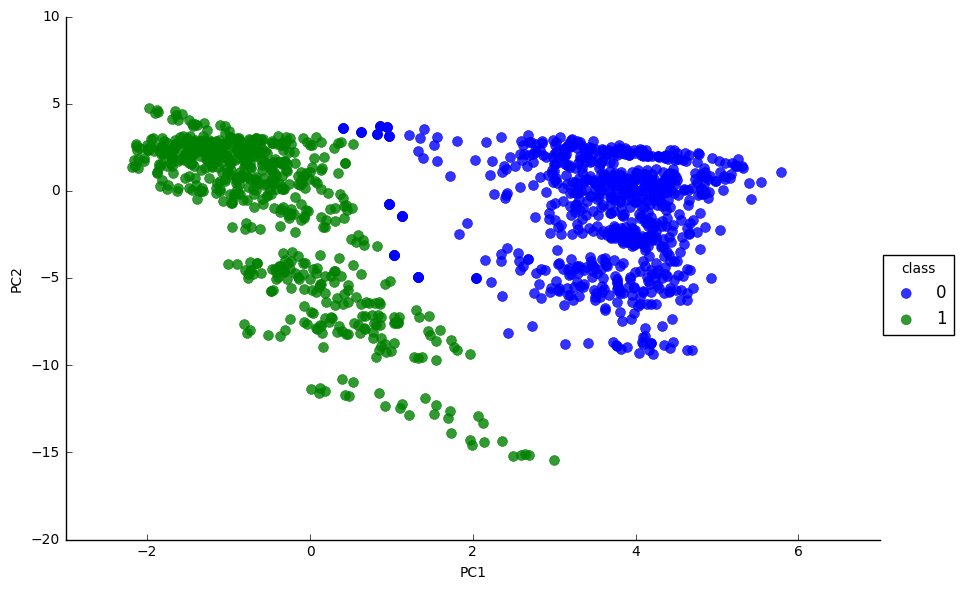

In [60]:
vis = sns.lmplot(data = df[["PC1","PC2","class"]], x = "PC1", y = "PC2",fit_reg=False, hue = "class",\
                 size = 6, aspect=1.5, scatter_kws = {'s':50}, )
vis.savefig("pca.png")

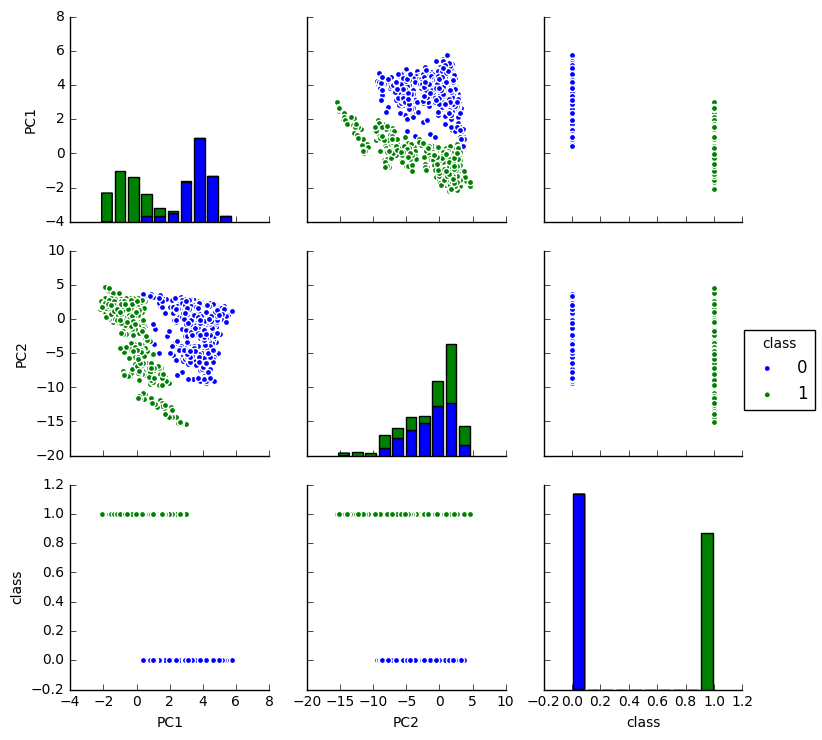

In [61]:
sns.pairplot(df[["PC1","PC2","class"]], hue="class")

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA(n_components=3)
X_lda = model.fit_transform(X, y)

In [65]:
print(model.explained_variance_ratio_.cumsum())

[ 1.]


In [68]:
df["PC1"] = X_lda[:,0]

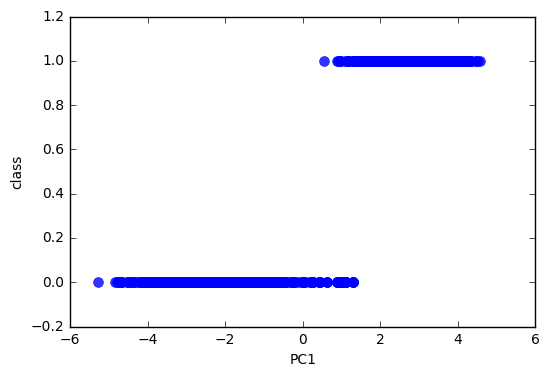

In [76]:
sns.regplot(data = df[["PC1","class"]], x = "PC1",y = "class", fit_reg=False,
            scatter_kws = {'s':50}, )